<a href="https://colab.research.google.com/github/cjdolan/HighResolutionSemanticClassification/blob/main/ATML_Build_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xmltodict
!pip install geopy
!pip install d2l
!pip install wget
!pip install utm
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
USERNAME = ""
PASSWORD = ""

In [2]:
import pandas as pd
import requests
from collections import defaultdict
import time
import json
import xml
import xml.etree.ElementTree as ET
import xmltodict
from tqdm import tqdm
from urllib.parse import urljoin
from shapely.geometry import Polygon
import numpy as np
import wget
from multiprocessing.pool import ThreadPool
import zipfile
from glob import glob
headers = {}
payload = {}

In [3]:
%%time
r = requests.get('https://overpass-api.de/api/interpreter?data=way[name=%22Fulton%20County%20Airport-Brown%20Field%22];(._;%3E;);way(around:40000)[aeroway=%22aerodrome%22];(._;%3E;);out%20center;')
xmltodict.parse(r.text)['osm']['way'][0]['center']

CPU times: user 83.8 ms, sys: 9.9 ms, total: 93.7 ms
Wall time: 1.26 s


{'@lat': '34.0143797', '@lon': '-84.5960295'}

In [4]:
def get_name(tags):
    if isinstance(tags, list):
        for t in tags:
            if t['@k'] == 'name':
                return t['@v']

In [5]:
def get_node(nodes, way_id):
  for n in nodes:
    if way_id == n['@id']:
      return n

def get_bb(nodes, ways):
  left = right = top = bottom = None
  for w in ways:
    node = get_node(nodes, w['@ref'])
    lat, lon = node['@lat'], node['@lon']
    if left == None:
      left = right = lon
      top = bottom = lat
    else:
      if lon < left:
        left = lon
      if lon > right:
        right = lon
      if lat < bottom:
        bottom = lat
      if lat > top:
        top = lat
  return left, right, top, bottom

get_bb(xmltodict.parse(r.text)['osm']['node'], xmltodict.parse(r.text)['osm']['way'][0]['nd'])

('-84.5835407', '-84.6085182', '34.0181462', '34.0106131')

In [6]:
def default_value():
    return -1

df = pd.DataFrame(columns=['Name', 'Lat', 'Long', 'Class'])

def get_addresses_of_poi(classes, tags, num_samples):
    result_total = []
    for i, t in enumerate(tags):
        poi_result = []
        seen = defaultdict(default_value)
        load_bar = tqdm(total=num_samples[i], position=0, leave=True)
        stack = []

        r = 40000
        n = 'Fulton County Airport-Brown Field'.replace(' ', '%20')
        k = t[0]
        v = t[1]
        query = 'https://overpass-api.de/api/interpreter?data=way\
                      (33.76,-84.52,33.78,-84.57)\
                      [name=%22{name}%22];\
                      (._;%3E;);way\
                      (around:{radius})[{key}=%22{value}%22];\
                      (._;%3E;);out%20center;'.format(key=k, value=v, name=n, radius=40000)
        result = requests.get(query)
        nodes = xmltodict.parse(result.text)['osm']['node']
        result = xmltodict.parse(result.text)['osm']['way']
        left, right, top, bottom = get_bb(nodes, result[0]['nd'])
        stack.append([get_name(result[0]['tag']), result[0]['center']['@lat'], result[0]['center']['@lon'], classes[i],
                     left, right, top, bottom])
        while stack:
            cur = stack[0]
            del stack[0]
            if seen[cur[0]] < 0:
                seen[cur[0]] = 1
                poi_result.append(cur)
                load_bar.update(1)
                center_point = (cur[1], cur[2])
                r = 40000
                if cur[0] != None:
                    try:
                        n = cur[0].replace(' ', '%20')
                        query = 'https://overpass-api.de/api/interpreter?data=way\
                                      [name=%22{name}%22];\
                                      (._;%3E;);way\
                                      (around:{radius})[{key}=%22{value}%22];\
                                      (._;%3E;);out%20center;'.format(key=k, value=v, name=n, radius=40000)
                        result = requests.get(query)
                        nodes = xmltodict.parse(result.text)['osm']['node']
                        result = xmltodict.parse(result.text)['osm']['way']
                        for way in result:
                            if isinstance(way, dict):
                                if seen[get_name(way['tag'])] < 0:
                                  left, right, top, bottom = get_bb(nodes, way['nd'])
                                  stack.append([get_name(way['tag']), way['center']['@lat'], way['center']['@lon'], classes[i],
                                               left, right, top, bottom])
                    except:
                        pass
            load_bar.set_description('POI: %s   Number of samples: %i' % (classes[i], len(poi_result)))
            if len(poi_result) > num_samples[i]:
                break

        result_total += poi_result

    return result_total, stack

r, s = get_addresses_of_poi(['airport'], [['aeroway', 'aerodrome']], [10])
new_df = pd.DataFrame(r, columns=['Name', 'Lat', 'Long', 'Class', 'Left', 'Right', 'Top', 'Bottom'])
df = pd.concat([df, new_df])
df.to_csv('./GeoData.csv')

POI: airport   Number of samples: 11:   1%|          | 11/1000 [00:20<30:18,  1.84s/it]


In [7]:
df.head(50)

,Name,Lat,Long,Class,Left,Right,Top,Bottom
0,Cobb County International Airport,34.0143797,-84.5960295,airport,-84.5835407,-84.6085182,34.0181462,34.0106131
1,Cartersville Airport,34.1233394,-84.8485850,airport,-84.8459369,-84.8512332,34.1334938,34.1131850
2,DeKalb-Peachtree Airport,33.8757978,-84.3018842,airport,-84.2944260,-84.3093423,33.8859337,33.8656620
3,Miller Farm Airport,33.6596506,-84.6616441,airport,-84.6561016,-84.6671866,33.6617830,33.6575182
4,Stockmar Airport,33.7559417,-84.8846365,airport,-84.8768347,-84.8924383,33.7573792,33.7545043
5,Downing Airport,34.1320727,-84.1991850,airport,-84.1969070,-84.2014631,34.1355549,34.1285905
6,Fulton County Airport-Brown Field,33.7764628,-84.5202996,airport,-84.5094166,-84.5311825,33.7825939,33.7703318
7,Richard B Russell Airport,34.3517623,-85.1590082,airport,-85.1502076,-85.1678088,34.3637073,34.3398173
8,Polk County Airport,34.0182657,-85.1447627,airport,-85.1347868,-85.1547386,34.0200902,34.0164412
9,Tom B David Field,34.4550866,-84.9387735,airport,-84.9353510,-84.9421960,34.4643247,34.4458484


In [8]:
API_URL = "https://m2m.cr.usgs.gov/api/api/json/stable/"
url = API_URL
session = requests.Session()

def login(username, password):
  """Get an API key.
  Parameters
  ----------
  username : str
      EarthExplorer username.
  password : str
      EarthExplorer password.
  """
  login_url = urljoin(url, "login")
  payload = {"username": username, "password": password}
  r = session.post(login_url, json.dumps(payload))
  session.headers["X-Auth-Token"] = r.json().get("data")

def get_resolution(metadata):
  for m in metadata:
    if m['fieldName'] == 'Resolution':
      return m['value']

def scene_search(lat1, lon1, lat2, lon2, datasetName='NAIP', maxResults=5):
  search_url = urljoin(url, "scene-search")
  spatialFilter = {
      'filterType': 'mbr',
      'lowerLeft': {
          'latitude':lat1,
          'longitude':lon1
      },
      'upperRight': {
          'latitude':lat2,
          'longitude':lon2
      }
  }
  cloudCoverFilter = {'min':0, 'max':5}
  sceneFilter = {'spatialFilter':spatialFilter, 'cloudCoverFilter':cloudCoverFilter}
  search_request = {'datasetName': datasetName, 'maxResults': maxResults, 'sceneFilter':sceneFilter, 'metadataType':'full'}
  r = session.post(search_url, json.dumps(search_request)).json()
  for result in r['data']['results']:
    res = get_resolution(result['metadata'])
    if float(res) == 1.0:
      return result['entityId'], result['spatialCoverage']['coordinates'][0]


def get_product_id(entityId):
  search_url = urljoin(url, "download-options")
  payload = {'datasetName':'NAIP', 'entityIds':[entityId]}
  r = session.post(search_url, json.dumps(payload)).json()
  return r['data'][0]['id'], r['data'][0]['displayId']


def download_scene(entityId, productId):
  dl_req_url = urljoin(url, "download-request")
  download_request = {
      'downloads': [{
        'entityId': entityId,
        'productId': productId
      }]
  }
  r = session.post(dl_req_url, json.dumps(download_request)).json()
  return r

def bulk_download_scene(entityId, productId):
  dl_req_url = urljoin(url, "download-request")
  downloads = []
  for i, e in enumerate(entityId):
    downloads.append({'entityId':e, 'productId':productId[i]})
  download_request = {
      'downloads': downloads
  }
  r = session.post(dl_req_url, json.dumps(download_request)).json()
  return r

def build_bb(points):
  return [(points[1], points[0]), (points[1], points[2]), (points[3], points[0]), (points[3], points[2])]

def overlap2(rect1,rect2):
    p1 = Polygon([rect1[0], rect1[1],rect1[2],rect1[3]])
    p2 = Polygon([rect2[0], rect2[1],rect2[2],rect2[3]])
    return(p1.intersects(p2))
rect1 = [[-84.6300721, 33.9973916], [-84.5593611, 33.9960083], [-84.5573805, 34.0651027], [-84.6281499, 34.0664888]]
rect2 = build_bb([34.0106131, -84.6085182, 34.0181462, -84.5835407])
print(overlap2(rect1,rect2))

True


In [9]:
import json
 
# Data to be written
dictionary = {
    "username": USERNAME,
    "password": PASSWORD
}
 
with open("data.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [10]:
import json
with open('data.json', 'r') as openfile:
  json_file = json.load(openfile)
  username, password = json_file['username'], json_file['password']
  login(username, password)
entityId = scene_search(34.0106131, -84.6085182, 34.0181462, -84.5835407)
product_id, file_name = get_product_id(entityId)

In [11]:
%%time
import json
with open('data.json', 'r') as openfile:
  json_file = json.load(openfile)
  username, password = json_file['username'], json_file['password']
  login(username, password)
  df['entity_id'] = ''
  df['product_id'] = ''
  for index, row in df.iterrows():
    if row.entity_id == '':
      try:
        entityId, scene_box = scene_search(float(row.Bottom), float(row.Right), float(row.Top), float(row.Left))
        product_id, file_name = get_product_id(entityId)
        df.at[index, 'entity_id'] = entityId
        df.at[index, 'product_id'] = product_id
        df.at[index, 'fileName'] = file_name
        temp = df[df.entity_id == '']
        for t_index, t_row in temp.iterrows():
          box = build_bb([t_row.Bottom, t_row.Right, t_row.Top, t_row.Left])
          if overlap2(scene_box, box):
            df.at[index, 'entity_id'] = entityId
            df.at[index, 'product_id'] = product_id
            df.at[index, 'fileName'] = file_name
      except:
        pass

CPU times: user 163 ms, sys: 11.5 ms, total: 175 ms
Wall time: 6.52 s


In [13]:
e_ids, p_ids = df[df.entity_id != '']['entity_id'].tolist(), df[df.entity_id != '']['product_id'].tolist()
with open('data.json', 'r') as openfile:
  json_file = json.load(openfile)
  username, password = json_file['username'], json_file['password']
  login(username, password)
  r = bulk_download_scene(e_ids, p_ids)
  while len(r['data']['preparingDownloads']) > 0:
    r = bulk_download_scene(e_ids, p_ids)

In [37]:
%%time
def download(url):
  wget.download(url['url'])

ThreadPool(9).imap_unordered(download, r['data']['availableDownloads'])

CPU times: user 3.24 ms, sys: 1.09 ms, total: 4.33 ms
Wall time: 6.94 ms


In [41]:
%%time
!mkdir data
def unzip(filename):
  with zipfile.ZipFile(filename, 'r') as f:
    f.extractall('./data/')

zip_files = glob('./*.ZIP')
ThreadPool(9).imap_unordered(unzip, zip_files)

CPU times: user 7.59 ms, sys: 21 ms, total: 28.6 ms
Wall time: 138 ms


In [46]:
def get_bounding_box(x_dim, y_dim, lat_min, lon_min, lat_max, lon_max):
  return x_dim*lon_min, x_dim*lon_max, y_dim*lat_min, y_dim*lat_max

In [64]:
df = df[~pd.isna(df.fileName)]

In [88]:
import utm
from osgeo import gdal
def get_utm(lon, lat, imgfile, x_or_y):
  u = utm.from_latlon(float(lat), float(lon))

  driver = gdal.GetDriverByName('GTiff')
  filename = '/content/data/' + imgfile.lower() + '.tif' #path to raster
  dataset = gdal.Open(filename)
  band = dataset.GetRasterBand(1)

  cols = dataset.RasterXSize
  rows = dataset.RasterYSize

  transform = dataset.GetGeoTransform()

  xOrigin = transform[0]
  yOrigin = transform[3]
  pixelWidth = transform[1]
  pixelHeight = -transform[5]

  data = band.ReadAsArray(0, 0, cols, rows)

  points_list = [(u[0], u[1])] #list of X,Y coordinates

  for point in points_list:
      col = int((point[0] - xOrigin) / pixelWidth)
      row = int((yOrigin - point[1] ) / pixelHeight)
  if x_or_y == 'x':
    return col
  return row

df['TopLeft_x'] = df.apply(lambda x: get_utm(x.Left, x.Bottom, x.fileName, 'x'), axis=1)
df['TopLeft_y'] = df.apply(lambda x: get_utm(x.Left, x.Bottom, x.fileName, 'y'), axis=1)

df['BottomRight_x'] = df.apply(lambda x: get_utm(x.Right, x.Top, x.fileName, 'x'), axis=1)
df['BottomRight_y'] = df.apply(lambda x: get_utm(x.Right, x.Top, x.fileName, 'y'), axis=1)

In [86]:
from d2l import torch as d2l

def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(6556, 7672)


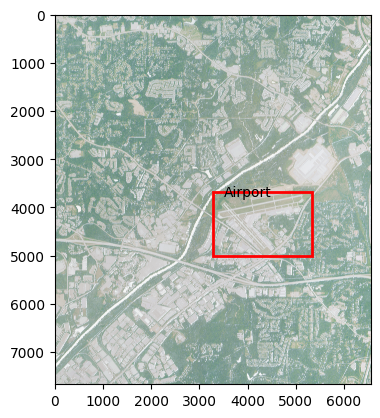

In [93]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches

temp = df.iloc[5]

path = '/content/data/' + temp.fileName.lower() + '.tif'
with Image.open(path) as image:
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)
    print(image.size)
    # Create a Rectangle patch
    rect = patches.Rectangle((temp.utm_y_tl, temp.utm_x_tl), temp.utm_y_br - temp.utm_y_tl, temp.utm_x_br - temp.utm_x_tl, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(bbox_to_rect([temp.TopLeft_x, temp.TopLeft_y, temp.BottomRight_x, temp.BottomRight_y], 'red'))
    ax.annotate('Airport', ((image.size[0]*temp['Left_pixel'] + image.size[0]*temp['Right_pixel'])/2.5,
                             image.size[1]*(1-temp['Top_pixel'])))

    plt.show()